# High Value Customer Indentification

## 1. Objetivo 

Desenvolver um modelo de **clusterização para identificar clientes de alto valor** em uma base de e-commerce, definindo de forma objetiva quem deve compor o **programa de Insiders**.
Como resultado, o projeto deverá:

* Gerar uma lista de clientes elegíveis ao programa no formato:

| customer_id | is_insider |
|-------------|------------|
| 1314        | 1          |

* Fornecer um relatório analítico respondendo às principais perguntas de negócio:

1. **Quem são os clientes elegíveis** para participar do programa de insiders?

2. **Quantos clientes** farão parte do grupo?

3. **Quais as principais características** desses clientes?

4. **Qual a porcentagem de contribuição do faturamento**, vinda do insiders?

5. **Qual a expectativa de faturamento** desse grupo para os próximos meses?

6. **Quais as condições para uma pessoa ser elegível** ao grupo insiders?

7. **Quais as condições para uma pessoa ser removida** dos insiders?

8. **Qual a garantia que o programa Insiders é melhor** que o restante da base?

9. **Quais ações o time de marketing pode realizar para aumentar** o faturamento?

## 2. Sumário Executivo

Este projeto teve como objetivo identificar, de forma objetiva e orientada por dados, os **clientes de maior valor de um e-commerce** e definir quem deve compor o **Programa de Insiders**, permitindo estratégias mais inteligentes de retenção, fidelização e crescimento de receita.

Através da aplicação de um modelo de **clusterização GMM (Euclidean)**, com excelente qualidade de segmentação demonstrada por um **Silhouette Score de 0,7048**, foi possível dividir a base de clientes em **6 clusters com perfis comportamentais e financeiros claramente distintos**. Cada grupo apresentou padrões específicos de compra, recorrência, engajamento, risco operacional e contribuição de faturamento, permitindo uma visão estratégica aprofundada sobre a base.

Entre os clusters gerados, o **Cluster 1** se destacou de forma inequívoca como o grupo de maior valor estratégico. Este grupo reúne:

* **419 clientes (14,8% da base)**
* Responsáveis por aproximadamente **62,3% de todo o faturamento**
* Maior gross revenue, maior número de pedidos, maior volume comprado
* **Alta frequência de compra e baixa recência**
* **Maior lifetime**
* **Baixa taxa de devolução**
* **Maior monetary_per_day** da base

Esses clientes compram com mais frequência, há mais tempo, gastam mais e geram menos custo operacional, tornando-se naturalmente os **Insiders** do negócio. Projeções baseadas no comportamento atual indicam potencial de **mais de R$ 1 milhão de faturamento em 30 dias** e cerca de **R$ 3 milhões em 90 dias**, evidenciando sua relevância não só histórica, mas também futura.

Além de identificar o grupo VIP, o projeto entregou:

* **Critérios claros de elegibilidade** para entrar no Insider (alto valor, alta recorrência, engajamento consistente e baixo risco)
* **Critérios objetivos de saída**, garantindo controle de qualidade do programa (queda de frequência, aumento de recência, redução de receita ou aumento de devoluções)
* Evidência analítica de que o Insider é **significativamente superior ao restante da base**
* Um plano estratégico de atuação para cada cluster, equilibrando:

  * retenção dos VIPs,
  * aceleração de clientes promissores,
  * recuperação de clientes em churn,
  * e controle de riscos em clientes problemáticos.

Em síntese, o projeto não entrega apenas um modelo analítico, mas uma **ferramenta de decisão de negócio**, capaz de:

* Priorizar os clientes que realmente importam
* Direcionar investimentos de marketing com maior eficiência
* Aumentar receita e retenção
* Reduzir desperdícios e riscos
* Sustentar decisões estratégicas com evidência estatística

O resultado final comprova que a aplicação de **Data Science e Machine Learning** é fundamental para transformar a gestão de clientes, tornando o programa de fidelidade mais inteligente, lucrativo e orientado a valor real.


## 3. Sobre os Dados

A base de dados utilizada vem de um e-commerce internacional e contém registros reais de compras feitas por clientes ao longo do tempo. Cada linha representa uma transação e inclui informações como número da fatura, produto comprado, quantidade, preço, data da compra, identificação do cliente e país. Com esses dados, é possível entender o comportamento dos clientes, como quanto compram, com que frequência retornam, quanto tempo permanecem ativos e quanto contribuem em faturamento, permitindo análises de valor de cliente, segmentação e criação de estratégias de negócio mais inteligentes.


## 4. Iniciando

### 4.1 Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
import umap.umap_ as umap
from sklearn.preprocessing import  MinMaxScaler
import ydata_profiling
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture






### 4.2 Importação de Estilo

In [2]:


plt.style.use('../styles/personalestilo.mplstyle')




Bad key axes.color_cycle in file ../styles/personalestilo.mplstyle, line 9 ('axes.color_cycle: df691b, 5cb85c, 5bc0de, f0ad4e, d9534f, 4e5d6c')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.0/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


### 4.3 Funções Adicionais

In [ ]:

def snake_case(lst):
    def convert(s):
        s = s.replace(' ', '_')
        new_s = ""
        for i, c in enumerate(s):
            if c.isupper():
                if i > 0 and (s[i-1].islower() or (i+1 < len(s) and s[i+1].islower())):
                    new_s += "_"
                new_s += c.lower()
            else:
                new_s += c
        return new_s
    return [convert(s) for s in lst]

def get_cluster_profile(df, cluster_col='cluster', id_col='customer_id'):
    total_customers = df[id_col].nunique()
    feature_cols = [col for col in df.columns if col not in [id_col, cluster_col]]
    agg_dict = {
        id_col: 'nunique'
    }
    for col in feature_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            agg_dict[col] = 'mean'
    cluster_profile = df.groupby(cluster_col).agg(agg_dict).reset_index()
    cluster_profile = cluster_profile.rename(columns={id_col: 'num_customers'})
    cluster_profile['perc_customers'] = (cluster_profile['num_customers'] / total_customers * 100).round(2)
    display(cluster_profile)
    return cluster_profile

### 4.4 Carregando os Dados

In [ ]:
df_raw = pd.read_csv('../data/ecommerce.csv', encoding='latin1').drop(columns=["Unnamed: 8"])


## 5. Descrição dos Dados

In [5]:
df1 = df_raw.copy()

In [6]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


### 5.1 Renomeando Colunas

In [7]:
df1.columns = snake_case(df1.columns)

### 5.2 Dimensão dos Dados

In [8]:
print(f'Dimensões do DataFrame: {df1.shape[0]} linhas, {df1.shape[1]} colunas')


Dimensões do DataFrame: 541909 linhas, 8 colunas


### 5.3 Tipos dos Dados

In [9]:
df1.dtypes


invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [10]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')
df1['customer_id'] = df1['customer_id'].astype('Int64')




### 5.4 Check e Fillout NaN

In [11]:
print('Valores ausentes por coluna:')
print(df1.isna().sum())


Valores ausentes por coluna:
invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64


In [12]:

mask_nan_cust = df1['customer_id'].isna()

invoice_groups = df1.loc[mask_nan_cust, 'invoice_no'].unique()

invoice_to_custid = {inv: cid for cid, inv in enumerate(invoice_groups, start=19000)}

df1.loc[mask_nan_cust, 'customer_id'] = df1.loc[mask_nan_cust, 'invoice_no'].map(invoice_to_custid)

df1['customer_id'] = df1['customer_id'].astype('Int64')

df1 = df1[df1['customer_id'] != 16446]

df1 = df1.drop('description', axis=1)

df1 = df1[~df1['country'].isin(['European Community', 'Unspecified'])]

df1 = df1[df1['unit_price'] >= 0.04].copy()

df1 = df1[~df1['stock_code'].str.fullmatch(r'[A-Za-z]+')]

df1_returns = df1[df1['quantity'] < 0].copy()
df1_purchase = df1[df1['quantity'] > 0].copy()


In [13]:
print('Valores ausentes por coluna:')
print(df1.isna().sum())

Valores ausentes por coluna:
invoice_no      0
stock_code      0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64


### 5.5 Estatística Descritiva

In [14]:
df_numeric = df1.select_dtypes(include=['int64', 'float64', 'Int64'])
df_categoric = df1.select_dtypes(include=['object'])


#### 5.5.1 Variáveis Númericas

In [15]:
numerical_stats = pd.DataFrame({
    'mean': df_numeric.mean(),
    'median': df_numeric.median(),
    'std': df_numeric.std(),
    'min': df_numeric.min(),
    'max': df_numeric.max(),
    'range': df_numeric.max() - df_numeric.min(),
    'skew': df_numeric.skew(),
    'kurtosis': df_numeric.kurt()
})

display(numerical_stats)



,mean,median,std,min,max,range,skew,kurtosis
quantity,9.905463,3.0,148.429964,-74215.0,74215.0,148430.0,0.317835,233158.512277
unit_price,3.311659,2.08,5.344376,0.04,1050.15,1050.11,52.769587,6973.649182
customer_id,16672.382766,16241.0,2897.685605,12346.0,22709.0,10363.0,0.50036,-0.777262


## 6. Feature Engineering

In [16]:
df2 = df1.copy()

### 6.1 Criação de Variáveis

In [17]:
df_ref = df2[['customer_id']].drop_duplicates().reset_index(drop=True)


#### 6.1.1 Gross Revenue

In [ ]:
gross_revenue = (
    df1_purchase.groupby('customer_id')
        .apply(lambda x: (x['quantity'] * x['unit_price']).sum())
        .reset_index(name='gross_revenue')
)

df_ref = df_ref.merge(gross_revenue, on='customer_id', how='left')

C:\Users\Patryck\AppData\Local\Temp\ipykernel_5492\4049961655.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['quantity'] * x['unit_price']).sum())


#### 6.1.2 Recency

In [19]:

max_date = df1_purchase['invoice_date'].max()
recency = (
    df1_purchase.groupby('customer_id')['invoice_date']
    .max()
    .reset_index()
)
recency['recency'] = (max_date - recency['invoice_date']).dt.days
recency = recency[['customer_id', 'recency']]
df_ref = df_ref.merge(recency, on='customer_id', how='left')


#### 6.1.3 Quantidade de Produtos Comprados

In [ ]:

qtd_produtos = (
    df1_purchase.groupby('customer_id')
        .apply(lambda x: x['quantity'].sum())
        .reset_index(name='qtd_produtos')
)

df_ref = df_ref.merge(
    qtd_produtos[['customer_id', 'qtd_produtos']], 
    on='customer_id', 
    how='left'
)


C:\Users\Patryck\AppData\Local\Temp\ipykernel_5492\499747772.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['quantity'].sum())


#### 6.1.4 Quantidade de Compras

In [21]:
quantidade_compras = (
    df1_purchase.groupby('customer_id')['invoice_no']
    .nunique()
    .reset_index(name='orders_count')
)
df_ref = df_ref.merge(quantidade_compras, on='customer_id', how='left')

#### 6.1.6 Frequency

In [22]:
frequency = ( df1_purchase .sort_values(['customer_id', 'invoice_date']) .drop_duplicates(subset=['customer_id', 'invoice_no', 'invoice_date']) .groupby('customer_id')['invoice_date'] .apply(lambda x: x.sort_values().diff().dt.days.mean() if len(x) > 1 else (np.nan)) .reset_index(name='frequency_days') ) 

df_ref = df_ref.merge(frequency, on='customer_id', how='left')



#### 6.1.7 Numero de Devoluções

In [23]:
returns = (
    df1_returns
        .groupby('customer_id')['quantity']
        .sum()
        .abs()
        .reset_index(name='returns')
)

df_ref = df_ref.merge(returns, on='customer_id', how='left')
df_ref['returns'] = df_ref['returns'].fillna(0)

df_ref['returns_rate'] = df_ref['returns'] / df_ref['qtd_produtos']



#### 6.1.12 Monetary Per Day

In [ ]:

lifetime = (
    df1_purchase
        .sort_values(['customer_id', 'invoice_date'])
        .groupby('customer_id')['invoice_date']
        .agg(['min', 'max'])
        .reset_index()
)
lifetime['lifetime_days'] = (lifetime['max'] - lifetime['min']).dt.days + 1  

df_ref = df_ref.merge(lifetime[['customer_id', 'lifetime_days']], on='customer_id', how='left')

df_ref['lifetime_days'] = df_ref['lifetime_days'].replace([np.inf, -np.inf], 0).fillna(0)

df_ref['monetary_per_day'] = (
    df_ref['gross_revenue'] / df_ref['lifetime_days']
)

df_ref['monetary_per_day'] = df_ref['monetary_per_day'].replace([np.inf, -np.inf], 0).fillna(0)



In [25]:
df_ref = df_ref.dropna()

## 7. Análise Exploratória dos Dados

In [26]:
df3 = df_ref.copy()

### 7.1 Análise Univariada

In [ ]:


profile = ydata_profiling.ProfileReport(df3, title='Pandas Profiling Report', explorative=True)
profile.to_file('../pdf/profile_report.html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 212.76it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 7.2 Análise Bivariada

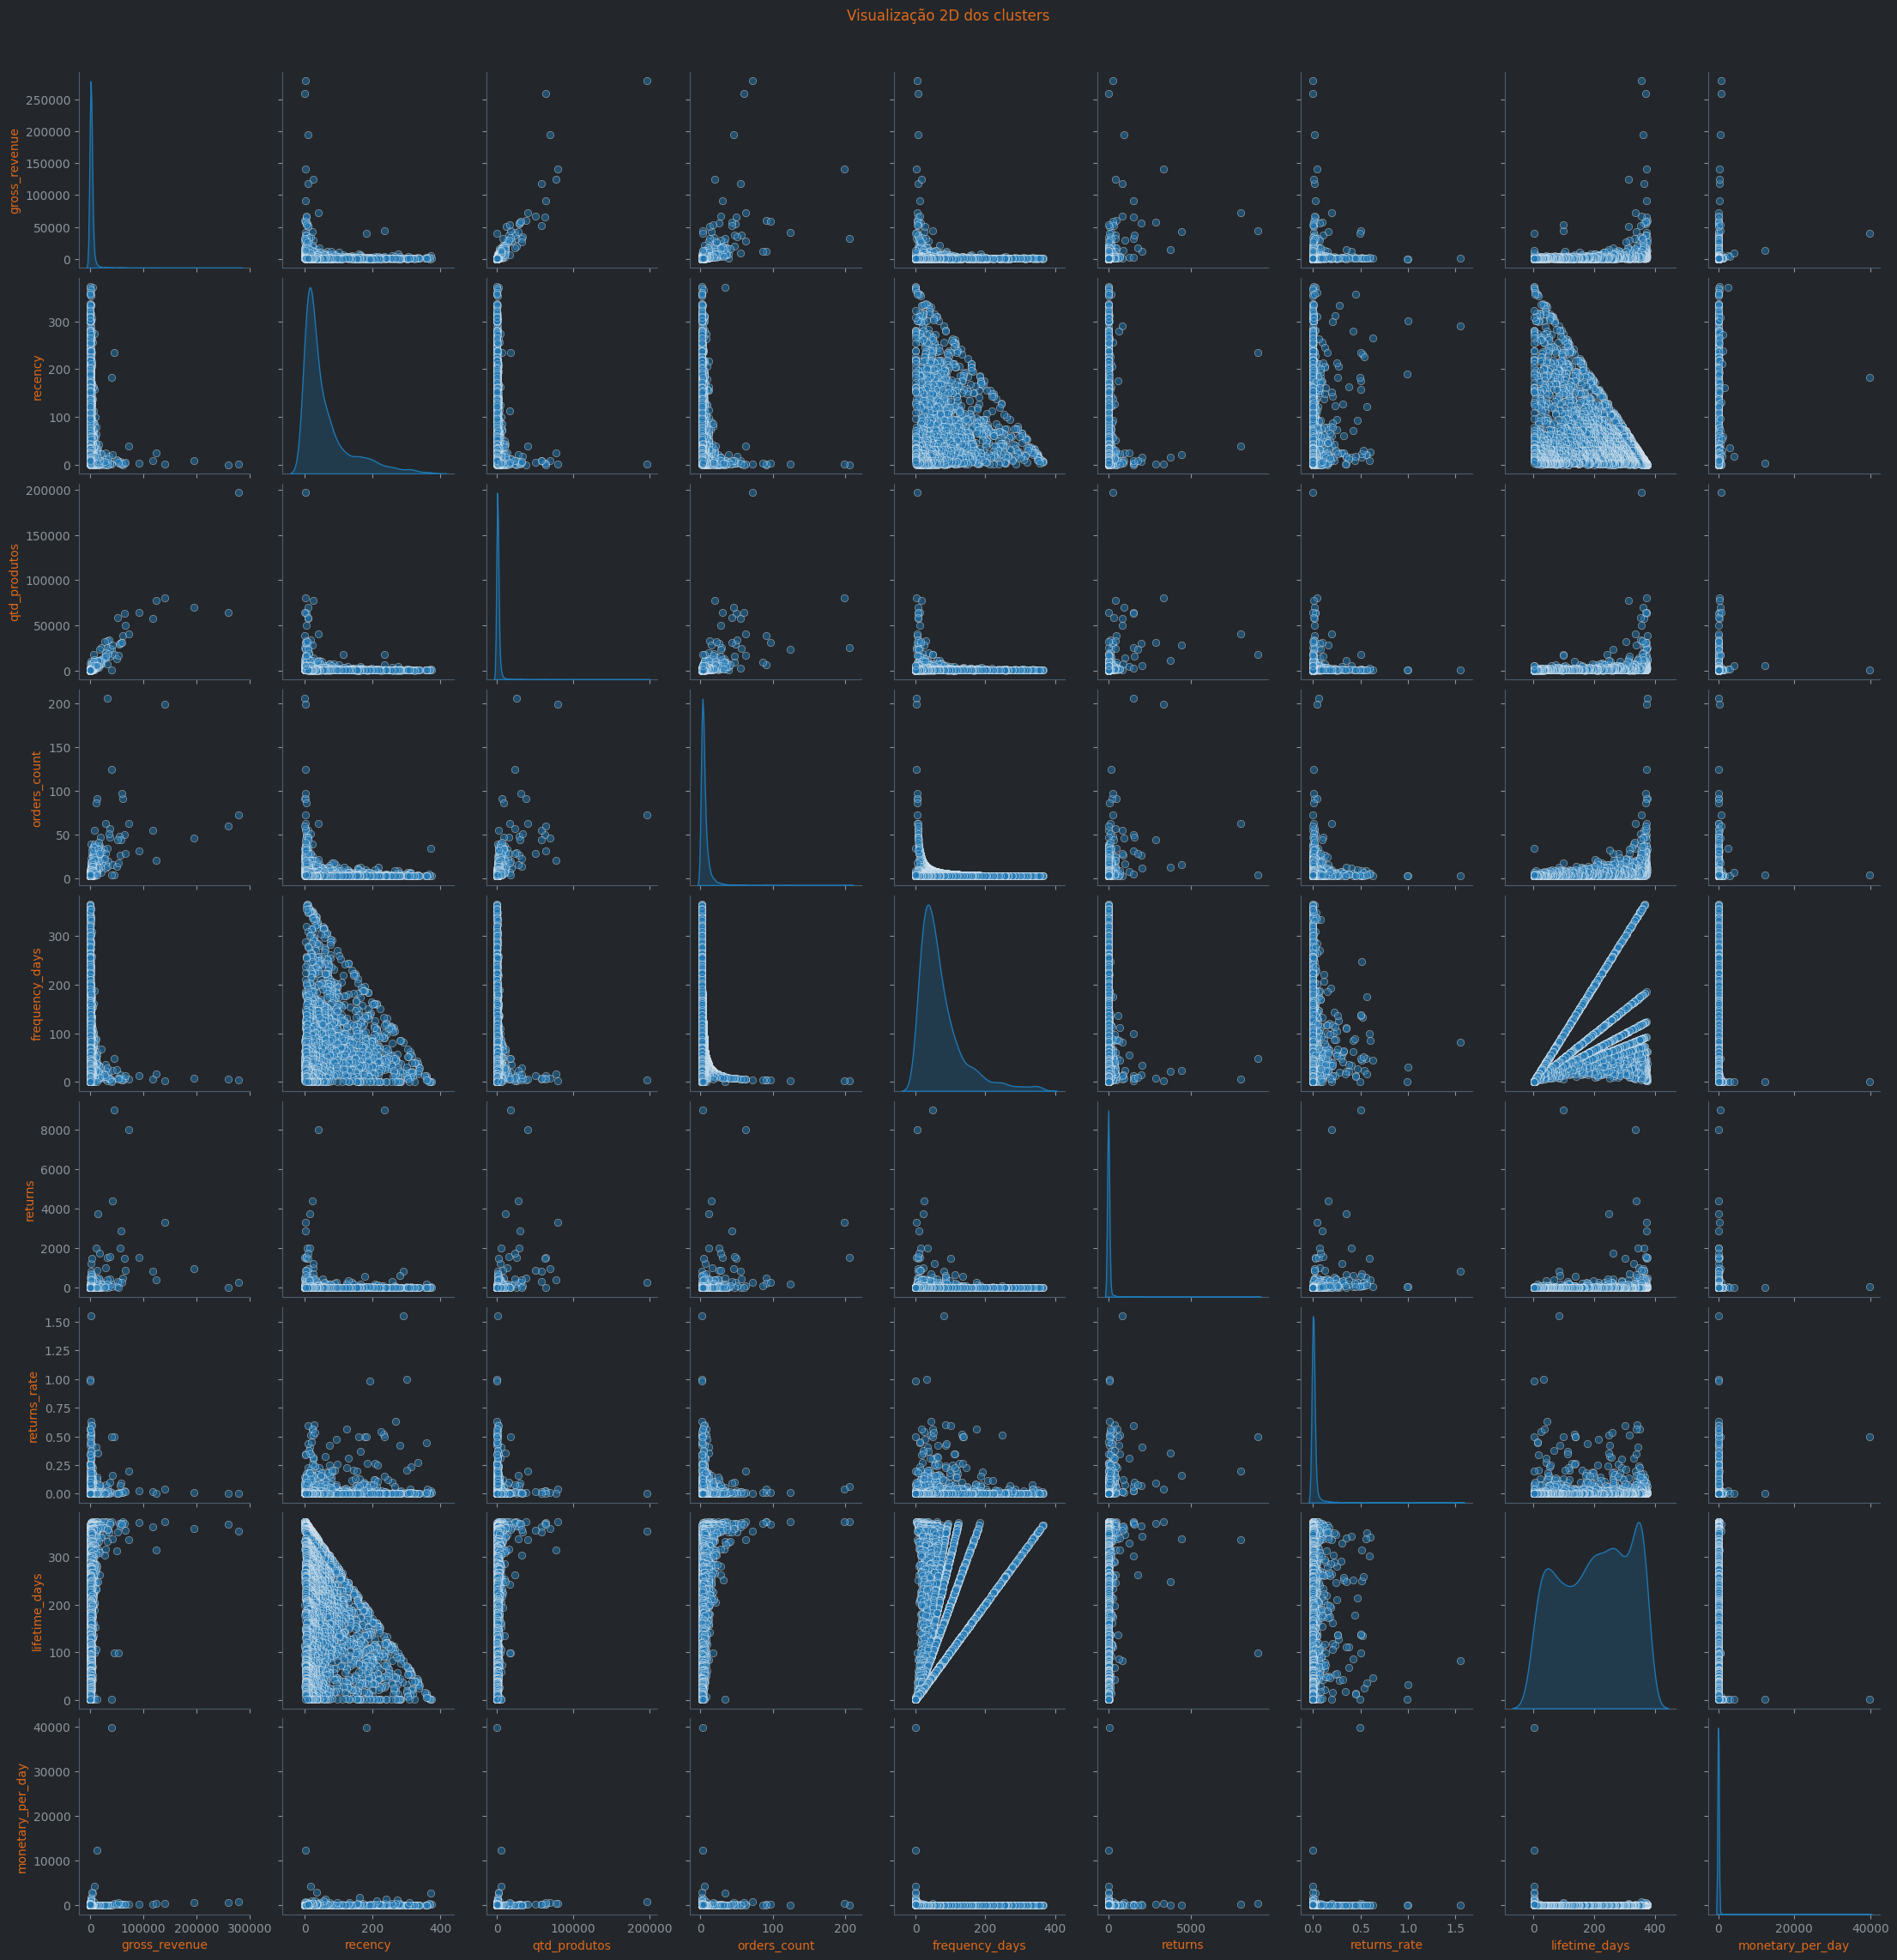

In [28]:
df_viz = df3.drop('customer_id', axis=1)
sns.pairplot(df_viz, diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Visualização 2D dos clusters', y=1.02)
plt.show()

### 7.3 Estudo do Espaço

In [29]:
df3v = df3.drop('customer_id', axis=1)

In [30]:
df3v.columns

Index(['gross_revenue', 'recency', 'qtd_produtos', 'orders_count',
       'frequency_days', 'returns', 'returns_rate', 'lifetime_days',
       'monetary_per_day'],
      dtype='object')

In [31]:
features_to_scale = [
    'gross_revenue', 'recency', 'qtd_produtos',
    'orders_count', 'frequency_days', 'returns', 'returns_rate', 'lifetime_days', 'monetary_per_day'
]

scaler = MinMaxScaler()
df3v_scaled = df3v.copy()
df3v_scaled[features_to_scale] = scaler.fit_transform(df3v[features_to_scale])



#### 7.3.1 PCA

C:\Users\Patryck\AppData\Local\Temp\ipykernel_5492\421556761.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([f'PC{i+1}' for i in range(len(explained_var))], rotation=45)


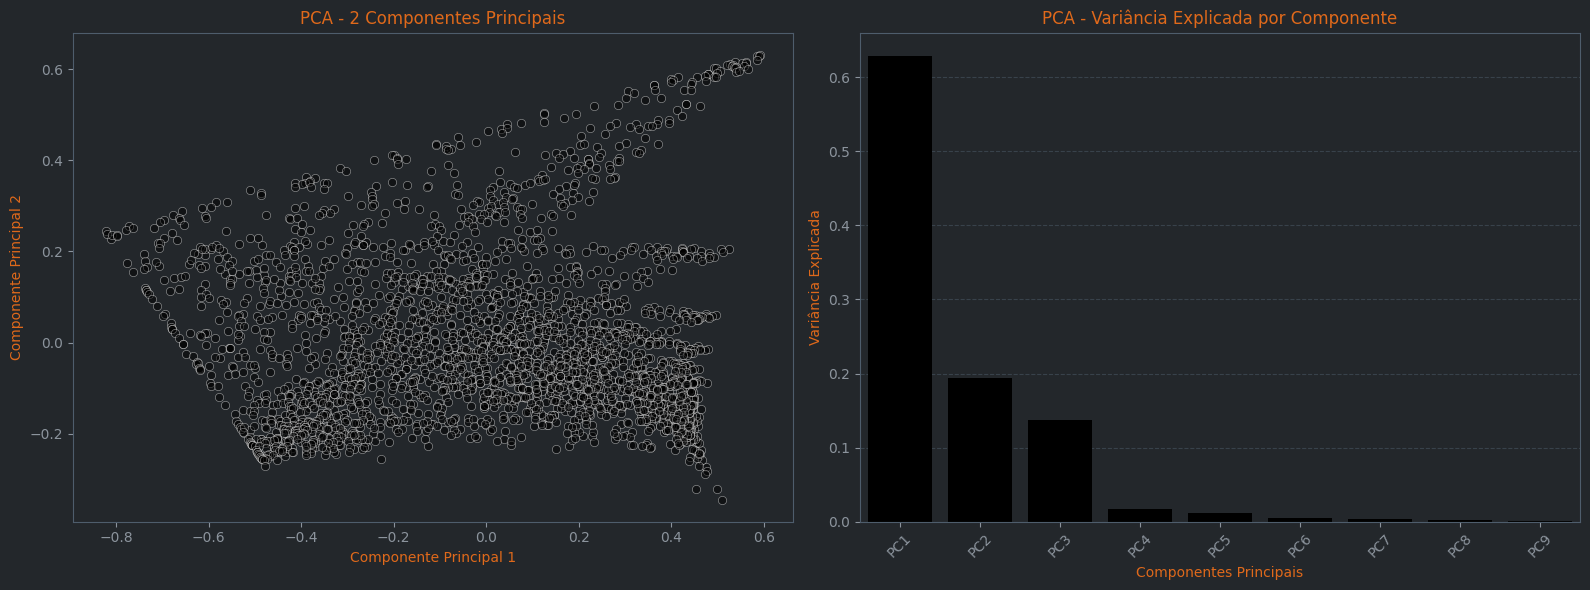

In [ ]:

n_components = df3v.shape[1]
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(df3v_scaled)

pc_columns = [f'PC{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(data=principal_components, columns=pc_columns)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x='PC1', y='PC2', data=df_pca, alpha=0.5, color='black', ax=axes[0])
axes[0].set_title('PCA - 2 Componentes Principais')
axes[0].set_xlabel('Componente Principal 1')
axes[0].set_ylabel('Componente Principal 2')

explained_var = pca.explained_variance_ratio_
sns.barplot(x=[f'PC{i+1}' for i in range(len(explained_var))], y=explained_var, color='black', ax=axes[1])
axes[1].set_ylabel('Variância Explicada')
axes[1].set_xlabel('Componentes Principais')
axes[1].set_title('PCA - Variância Explicada por Componente')
axes[1].set_xticklabels([f'PC{i+1}' for i in range(len(explained_var))], rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()



#### 7.3.2 UMAP

c:\Users\Patryck\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


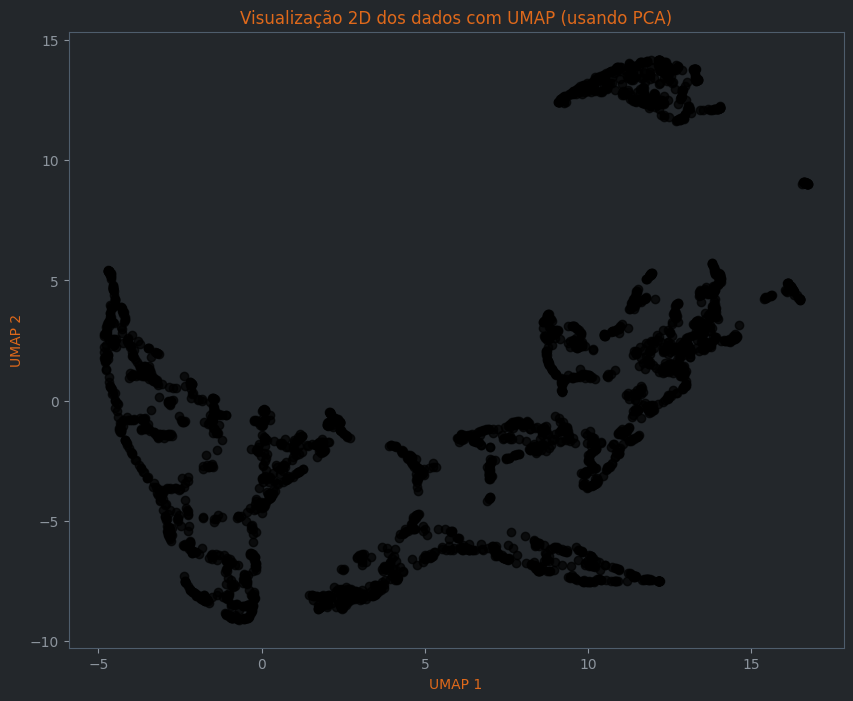

In [33]:
reducer = umap.UMAP(random_state=42)

umap_features = df_pca.copy()
embedding = reducer.fit_transform(umap_features)

plt.figure(figsize=(10, 8))
plt.scatter(
    embedding[:, 0], 
    embedding[:, 1], 
    color='black', 
    alpha=0.7
)
plt.title('Visualização 2D dos dados com UMAP (usando PCA)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

#### 7.3.3 T-SNE

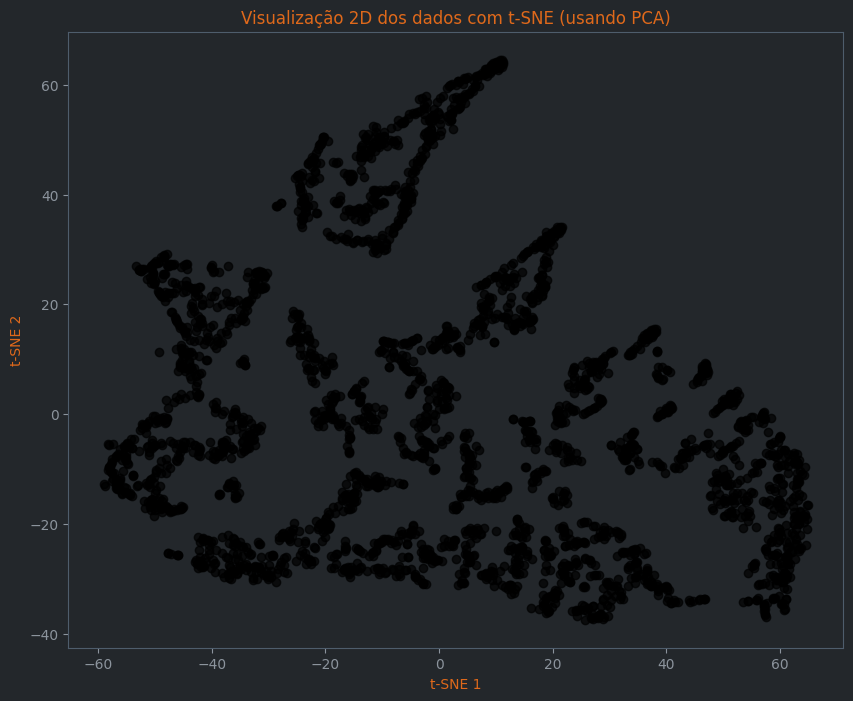

In [34]:
reducer = TSNE(random_state=42, n_components=2)

tsne_features = df_pca.copy()
embedding = reducer.fit_transform(tsne_features)

plt.figure(figsize=(10, 8))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    color='black',
    alpha=0.7
)
plt.title('Visualização 2D dos dados com t-SNE (usando PCA)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

#### 7.3.4 Tree-Based Embendding

c:\Users\Patryck\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


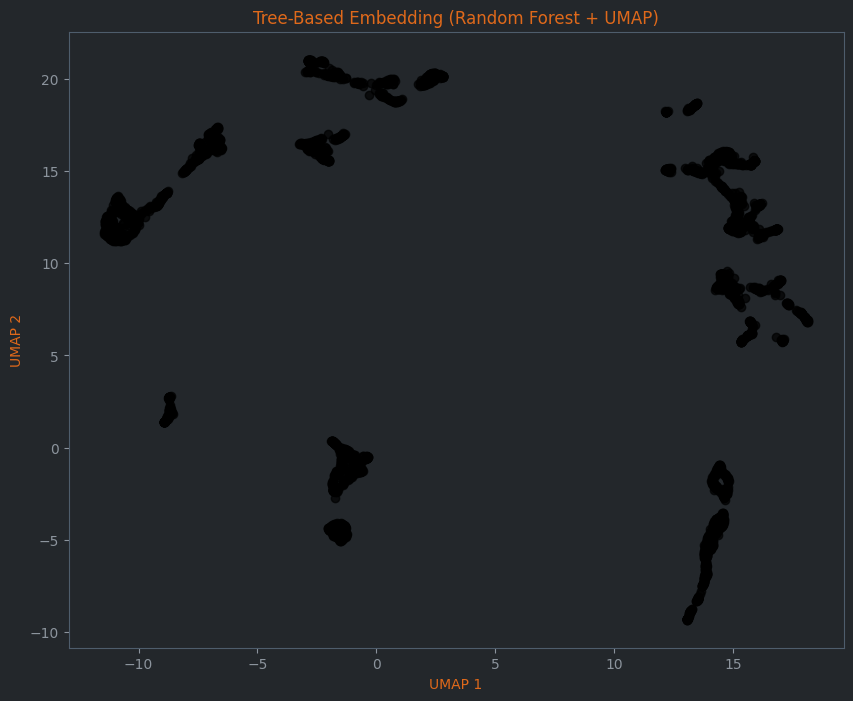

In [35]:

X = df3v.drop(columns=['gross_revenue'])
y = df3v['gross_revenue']

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X, y)

leaf_indices = rf.apply(X)

embedding_tree = pd.DataFrame(
    leaf_indices, 
    index=df3v.index, 
    columns=[f'leaf_{i}' for i in range(leaf_indices.shape[1])]
)

reducer = umap.UMAP(n_components=2, random_state=42)
tree_2d_umap_array = reducer.fit_transform(embedding_tree)

tree_2d_umap = pd.DataFrame(
    tree_2d_umap_array,
    index=df3v.index,
    columns=['UMAP_1', 'UMAP_2']
)

fig, ax = plt.subplots(figsize=(10,8))
scatter = ax.scatter(tree_2d_umap['UMAP_1'], tree_2d_umap['UMAP_2'], alpha=0.7, color='black')
ax.set_title('Tree-Based Embedding (Random Forest + UMAP)')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
plt.show()
plt.close(fig)




## 8. Fine Tunning

In [36]:
df4 = tree_2d_umap.copy()

In [37]:
X = df4.copy()


### 8.1 K-MEANS

K=2 - Silhouette Score: 0.5260
K=3 - Silhouette Score: 0.6027
K=4 - Silhouette Score: 0.6879
K=5 - Silhouette Score: 0.6972
K=6 - Silhouette Score: 0.6706
K=7 - Silhouette Score: 0.6424
K=8 - Silhouette Score: 0.6682
K=9 - Silhouette Score: 0.6223
K=10 - Silhouette Score: 0.6607
K=11 - Silhouette Score: 0.6842
K=12 - Silhouette Score: 0.6401
K=13 - Silhouette Score: 0.6525
K=14 - Silhouette Score: 0.6291
K=15 - Silhouette Score: 0.6231
K=16 - Silhouette Score: 0.6236
K=17 - Silhouette Score: 0.6247
K=18 - Silhouette Score: 0.6141
K=19 - Silhouette Score: 0.5955
K=20 - Silhouette Score: 0.5966
K=21 - Silhouette Score: 0.6415
K=22 - Silhouette Score: 0.6338
K=23 - Silhouette Score: 0.6198
K=24 - Silhouette Score: 0.5792


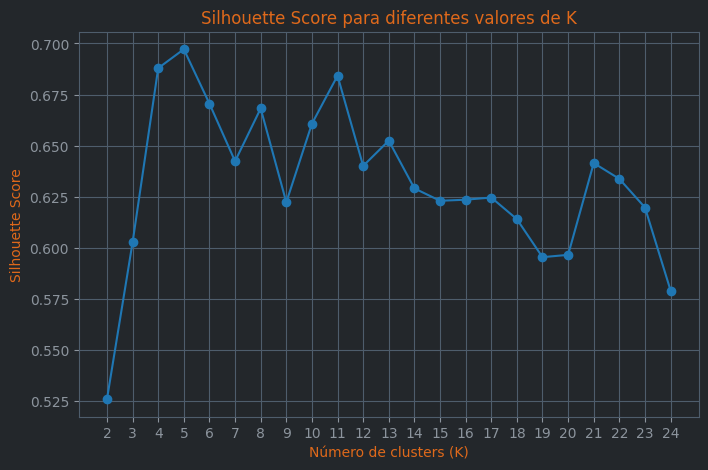


Melhor K de acordo com o Silhouette Score: 5 (Score: 0.6972)


In [ ]:
range_n_clusters = range(2, 25)
kmeans_silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300, init='random')
    labels = kmeans.fit_predict(X)
    sil_score = silhouette_score(X, labels)
    kmeans_silhouette_scores.append(sil_score)
    print(f"K={n_clusters} - Silhouette Score: {sil_score:.4f}")

plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, kmeans_silhouette_scores, marker='o')
plt.title('Silhouette Score para diferentes valores de K')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

best_k = range_n_clusters[kmeans_silhouette_scores.index(max(kmeans_silhouette_scores))]
print(f"\nMelhor K de acordo com o Silhouette Score: {best_k} (Score: {max(kmeans_silhouette_scores):.4f})")



### 8.2 GMM

K=2 - Silhouette Score: 0.5260
K=3 - Silhouette Score: 0.5891
K=4 - Silhouette Score: 0.6879
K=5 - Silhouette Score: 0.6972
K=6 - Silhouette Score: 0.7048
K=7 - Silhouette Score: 0.6793
K=8 - Silhouette Score: 0.6416
K=9 - Silhouette Score: 0.6767
K=10 - Silhouette Score: 0.6438
K=11 - Silhouette Score: 0.6823
K=12 - Silhouette Score: 0.6377
K=13 - Silhouette Score: 0.6880
K=14 - Silhouette Score: 0.6560
K=15 - Silhouette Score: 0.6654
K=16 - Silhouette Score: 0.6192
K=17 - Silhouette Score: 0.6044
K=18 - Silhouette Score: 0.6338
K=19 - Silhouette Score: 0.6362
K=20 - Silhouette Score: 0.6263
K=21 - Silhouette Score: 0.6196
K=22 - Silhouette Score: 0.6034
K=23 - Silhouette Score: 0.5981
K=24 - Silhouette Score: 0.5888


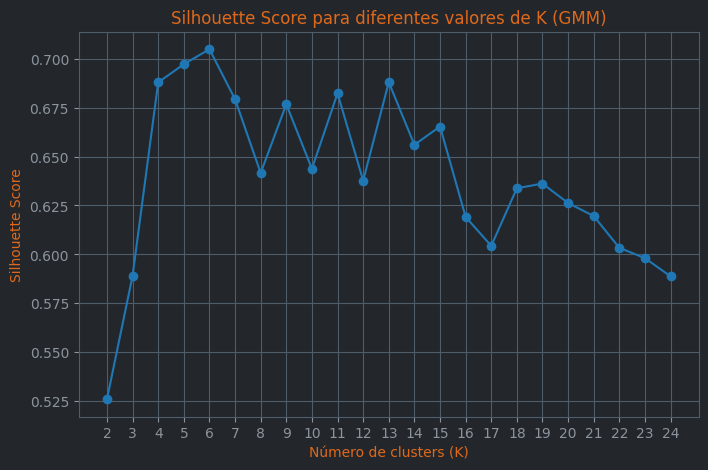


Melhor K de acordo com o Silhouette Score (GMM): 6 (Score: 0.7048)


In [ ]:
range_n_clusters = range(2, 25)
gmm_silhouette_scores = []

for n_clusters in range_n_clusters:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42, n_init=10, max_iter=300)
    gmm.fit(X)
    labels = gmm.predict(X)
    sil_score = silhouette_score(X, labels)
    gmm_silhouette_scores.append(sil_score)
    print(f"K={n_clusters} - Silhouette Score: {sil_score:.4f}")

plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, gmm_silhouette_scores, marker='o')
plt.title('Silhouette Score para diferentes valores de K (GMM)')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

best_k = range_n_clusters[gmm_silhouette_scores.index(max(gmm_silhouette_scores))]
print(f"\nMelhor K de acordo com o Silhouette Score (GMM): {best_k} (Score: {max(gmm_silhouette_scores):.4f})")

### 8.3 Hierarchical Clustering

Hierarchical clustering K=2 - Silhouette Score: 0.4847
Hierarchical clustering K=3 - Silhouette Score: 0.6018
Hierarchical clustering K=4 - Silhouette Score: 0.6879
Hierarchical clustering K=5 - Silhouette Score: 0.6972
Hierarchical clustering K=6 - Silhouette Score: 0.6706
Hierarchical clustering K=7 - Silhouette Score: 0.6793
Hierarchical clustering K=8 - Silhouette Score: 0.6682
Hierarchical clustering K=9 - Silhouette Score: 0.6517
Hierarchical clustering K=10 - Silhouette Score: 0.6602
Hierarchical clustering K=11 - Silhouette Score: 0.6289
Hierarchical clustering K=12 - Silhouette Score: 0.6523
Hierarchical clustering K=13 - Silhouette Score: 0.6471
Hierarchical clustering K=14 - Silhouette Score: 0.6579
Hierarchical clustering K=15 - Silhouette Score: 0.6505
Hierarchical clustering K=16 - Silhouette Score: 0.6612
Hierarchical clustering K=17 - Silhouette Score: 0.6567
Hierarchical clustering K=18 - Silhouette Score: 0.6293
Hierarchical clustering K=19 - Silhouette Score: 0.6361


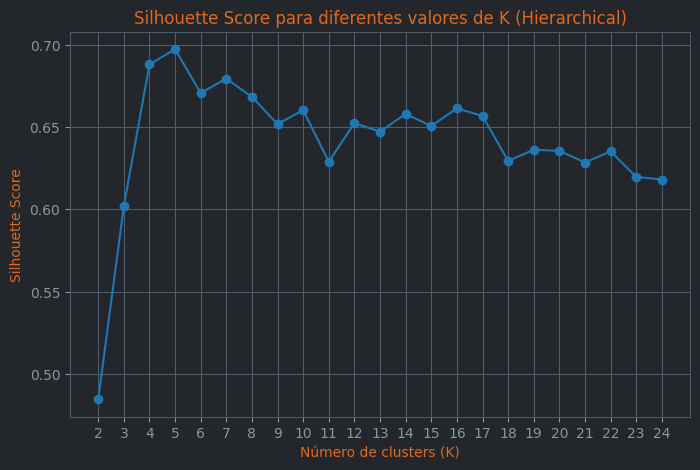


Melhor K de acordo com o Silhouette Score para o hierarchical clustering: 5 (Score: 0.6972)


In [ ]:

range_n_clusters = range(2, 25)
hclust_silhouette_scores = []

for n_clusters in range_n_clusters:
    hclust = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', metric='euclidean')
    labels = hclust.fit_predict(X)
    sil_score = silhouette_score(X, labels, metric='euclidean')
    hclust_silhouette_scores.append(sil_score)
    print(f"Hierarchical clustering K={n_clusters} - Silhouette Score: {sil_score:.4f}")

plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, hclust_silhouette_scores, marker='o')
plt.title('Silhouette Score para diferentes valores de K (Hierarchical)')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

best_k_hclust = range_n_clusters[hclust_silhouette_scores.index(max(hclust_silhouette_scores))]
print(f"\nMelhor K de acordo com o Silhouette Score para o hierarchical clustering: {best_k_hclust} (Score: {max(hclust_silhouette_scores):.4f})")


### 8.4 Resultados

In [ ]:

ks = list(range(2, 25))
scores_dict = {
    'KMeans': kmeans_silhouette_scores,
    'GMM': gmm_silhouette_scores,
    'Agglomerative': hclust_silhouette_scores,
}

scores_df = pd.DataFrame(
    [scores_dict[algo] for algo in scores_dict],
    columns=[f'K={k}' for k in ks],
    index=['KMeans', 'GMM', 'Agglomerative']
)

def highlight_best(s):
    is_max = s == s.max()
    return ['background-color: lightgreen; font-weight: bold' if v else '' for v in is_max]

display(scores_df.style.apply(highlight_best, axis=1))




,K=2,K=3,K=4,K=5,K=6,K=7,K=8,K=9,K=10,K=11,K=12,K=13,K=14,K=15,K=16,K=17,K=18,K=19,K=20,K=21,K=22,K=23,K=24
KMeans,0.526025,0.602701,0.687906,0.697174,0.670579,0.642400,0.668217,0.622331,0.660736,0.684229,0.640107,0.652465,0.629129,0.623062,0.623589,0.624653,0.614072,0.595490,0.596621,0.641513,0.633768,0.619774,0.579174
GMM,0.526025,0.589087,0.687906,0.697174,0.704840,0.679290,0.641613,0.676717,0.643753,0.682283,0.637725,0.687968,0.656000,0.665353,0.619151,0.604377,0.633813,0.636194,0.626253,0.619604,0.603360,0.598093,0.588789
Agglomerative,0.484689,0.601800,0.687906,0.697174,0.670579,0.679290,0.668217,0.651710,0.660210,0.628853,0.652341,0.647127,0.657913,0.650545,0.661232,0.656699,0.629345,0.636110,0.635493,0.628403,0.635162,0.619668,0.618052


### 8.5 Análise de Silhoueta

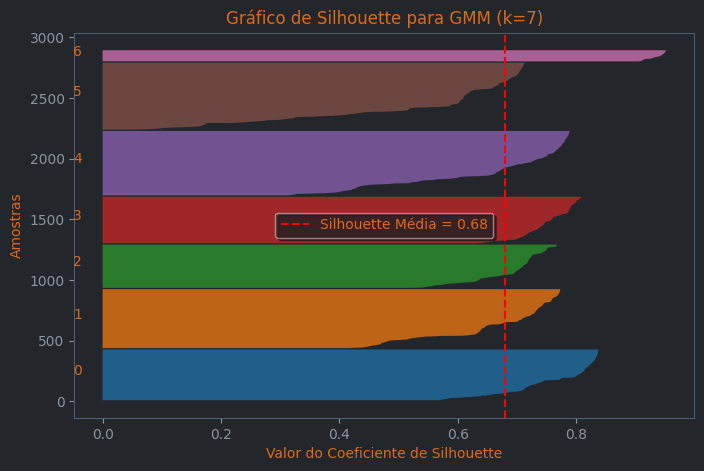

In [ ]:

gmm_7 = GaussianMixture(n_components=7, random_state=42)
gmm_labels = gmm_7.fit_predict(X)

silhouette_avg = silhouette_score(X, gmm_labels)
sample_silhouette_values = silhouette_samples(X, gmm_labels)

plt.figure(figsize=(8, 5))
y_lower = 10
for i in range(7):
    ith_cluster_silhouette_values = sample_silhouette_values[gmm_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, ith_cluster_silhouette_values,
        alpha=0.7
    )
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  

plt.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Silhouette Média = {silhouette_avg:.2f}")
plt.xlabel("Valor do Coeficiente de Silhouette")
plt.ylabel("Amostras")
plt.title("Gráfico de Silhouette para GMM (k=7)")
plt.legend()
plt.show()


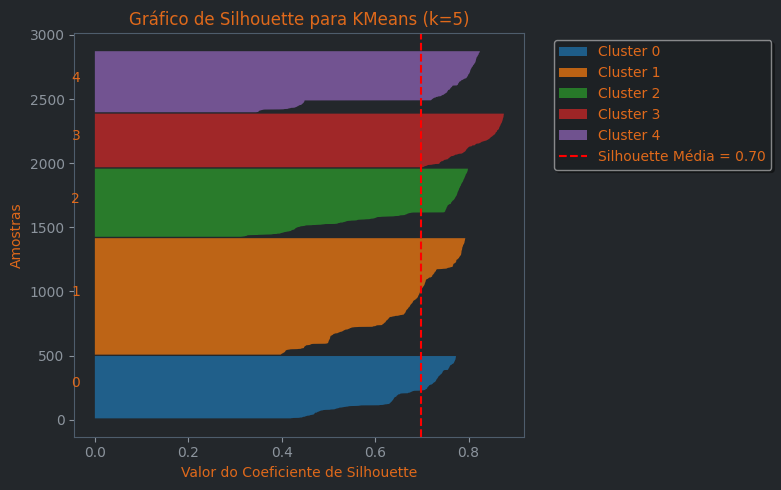

In [ ]:

kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10, max_iter=300, init='random')
kmeans_labels = kmeans_5.fit_predict(X)

silhouette_avg_kmeans = silhouette_score(X, kmeans_labels)
sample_silhouette_values_kmeans = silhouette_samples(X, kmeans_labels)

plt.figure(figsize=(8, 5))
y_lower = 10

n_clusters = 5
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values_kmeans[kmeans_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, ith_cluster_silhouette_values,
        alpha=0.7,
        label=f'Cluster {i}'
    )
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10 

plt.axvline(x=silhouette_avg_kmeans, color="red", linestyle="--", label=f"Silhouette Média = {silhouette_avg_kmeans:.2f}")
plt.xlabel("Valor do Coeficiente de Silhouette")
plt.ylabel("Amostras")
plt.title("Gráfico de Silhouette para KMeans (k=5)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



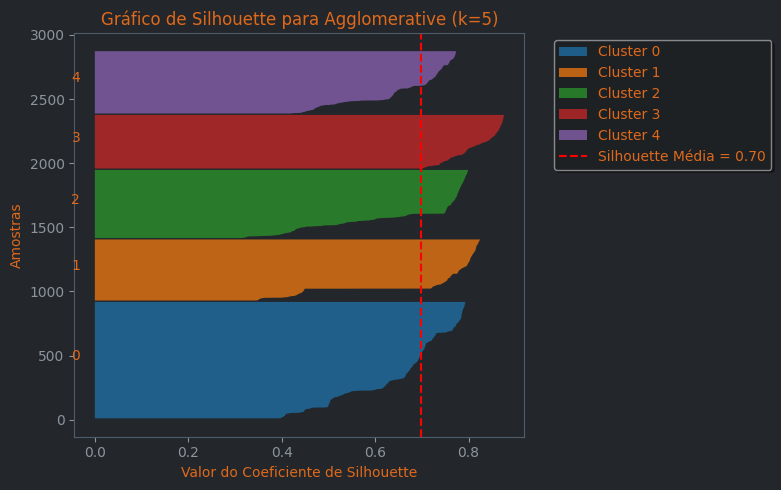

In [ ]:

agglo_5 = AgglomerativeClustering(n_clusters=5)
agglo_labels = agglo_5.fit_predict(X)

silhouette_avg_agglo = silhouette_score(X, agglo_labels)
sample_silhouette_values_agglo = silhouette_samples(X, agglo_labels)

plt.figure(figsize=(8, 5))
y_lower = 10
n_clusters = 5
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values_agglo[agglo_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, ith_cluster_silhouette_values,
        alpha=0.7,
        label=f'Cluster {i}'
    )
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  

plt.axvline(x=silhouette_avg_agglo, color="red", linestyle="--", label=f"Silhouette Média = {silhouette_avg_agglo:.2f}")
plt.xlabel("Valor do Coeficiente de Silhouette")
plt.ylabel("Amostras")
plt.title("Gráfico de Silhouette para Agglomerative (k=5)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 9. Machine Learning

In [46]:
df5 = df4.copy()
df5 = pd.DataFrame(df5)

### 9.1 K-Means

In [47]:
gmm = GaussianMixture(n_components=6, random_state=42, n_init=10, max_iter=300)
gmm.fit(X)

df5['cluster'] = gmm.predict(X)


In [ ]:

sil_score = silhouette_score(X, gmm.predict(X), metric='euclidean')
print(f"Silhouette Score do cluster (GMM - Euclidean): {sil_score:.4f}")

log_likelihood = gmm.score(X) * X.shape[0]
print(f"Log-likelihood do GMM: {log_likelihood:.4f}")


Silhouette Score do cluster (GMM - Euclidean): 0.7048
Log-likelihood do GMM: -13807.5059


## 10. Análise de Clusters

In [49]:
df6 = df5.copy()

### 10.1 Inspeção de Vizualização

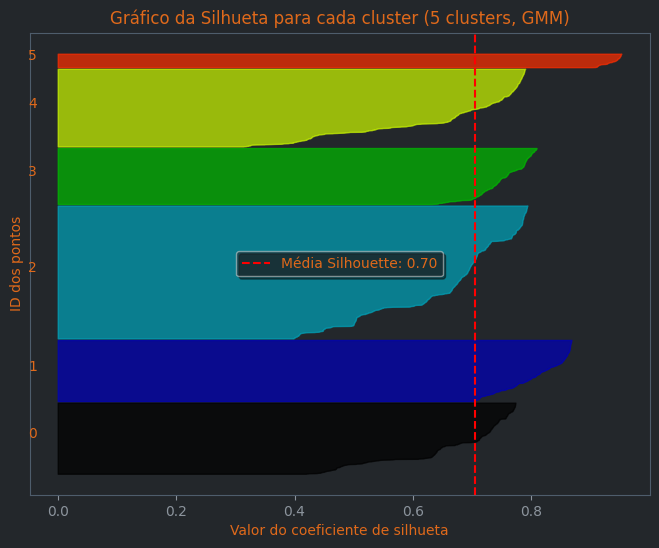

In [ ]:

gmm_labels = gmm.predict(X)
silhouette_vals = silhouette_samples(X, gmm_labels)

n_clusters =6
y_lower = 10
fig, ax1 = plt.subplots(figsize=(8, 6))

for i in range(n_clusters):
    ith_cluster_silhouette_values = silhouette_vals[gmm_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10 

ax1.set_title("Gráfico da Silhueta para cada cluster (5 clusters, GMM)")
ax1.set_xlabel("Valor do coeficiente de silhueta")
ax1.set_ylabel("ID dos pontos")

silhouette_avg = silhouette_score(X, gmm_labels)
ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Média Silhouette: {silhouette_avg:.2f}")

ax1.set_yticks([])
ax1.legend()
plt.show()


### 10.2 Vizualização dos Clusters

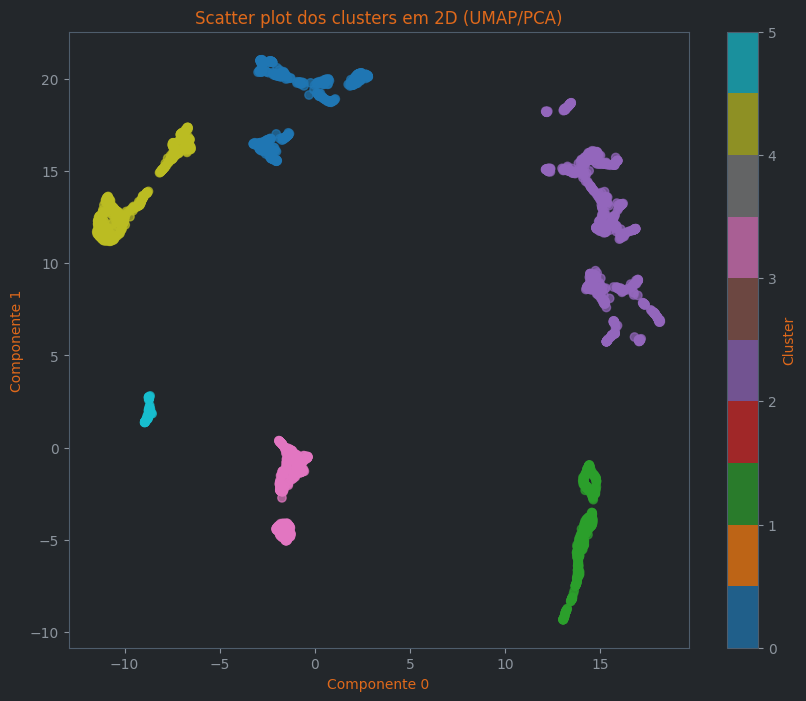

In [51]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(df6['UMAP_1'], df6['UMAP_2'], c=df6['cluster'], cmap='tab10', alpha=0.7)
plt.xlabel('Componente 0')
plt.ylabel('Componente 1')
plt.title('Scatter plot dos clusters em 2D (UMAP/PCA)')
plt.colorbar(scatter, label='Cluster')
plt.show()

### 10.3 Cluster Profile

In [52]:
df3['cluster'] = df6['cluster']
cluster_profile = get_cluster_profile(df3, cluster_col='cluster', id_col='customer_id')


,cluster,num_customers,gross_revenue,recency,qtd_produtos,orders_count,frequency_days,returns,returns_rate,lifetime_days,monetary_per_day,perc_customers
0,0,487,1052.714517,62.100616,615.078029,3.340862,80.731422,9.252567,0.015602,167.868583,30.524998,17.25
1,1,419,11843.508473,22.155131,7036.410501,16.417661,33.412178,166.004773,0.017211,295.300716,81.955053,14.84
2,2,909,2155.753619,39.850385,1266.741474,6.336634,58.374603,21.325633,0.017752,242.861386,62.603447,32.19
3,3,384,349.490833,100.705729,132.130208,2.468750,98.494829,2.479167,0.022043,129.255208,22.240232,13.60
4,4,532,661.282707,78.958647,348.048872,2.697368,96.863095,4.323308,0.012212,147.319549,23.767587,18.84
5,5,93,488.165806,82.397849,225.537634,2.677419,114.438710,5.075269,0.023009,154.569892,16.382966,3.29


#### Cluster 0


**Cluster 0 – Clientes Medianos Ativos**

**(487 clientes | 17.2% da base)**

**Perfil**

* Receita baixa: 1052
* Compram relativamente pouco
* Frequência razoável: 3.3 pedidos
* Recency relativamente alto: 62 dias
* Lifetime bom: 167 dias
* Taxa de devolução baixa: 1.5%
* monetary_per_day médio-baixo: 30.5

**Interpretação**
Clientes que já compraram razoavelmente, mas não escalaram.
Não são ruins, não são ótimos, estão em uma **zona de oportunidade**.

**Ações**

* Campanhas de estímulo: cupons / bundles
* Incentivar segunda/terceira compra
* Educação do cliente sobre produtos
* Programas de upgrade para cluster 2

**Objetivo:** aumentar ticket + recorrência

#### Cluster 1

**Cluster 1 – Clientes Elite / High Value Insiders**

**(419 clientes | 14.8% da base | maior receita absoluta e por dia)**

**Perfil**

* **Maior gross_revenue**: 11.8k em média
* **Maior volume comprado**: 7.036 produtos em média
* **Altíssimo número de pedidos**: 16.4
* **Clientes muito ativos recentemente**: recency 22 dias
* **Baixa taxa de devolução**: 1.7%
* **Maior lifetime**: 295 dias
* **Altíssimo monetary_per_day**: 81.9

**Interpretação**
Este é claramente o grupo **VIP / Insider** natural.
São clientes que compram muito, compram com frequência, têm relacionamento de longo prazo e retorno financeiro altíssimo com baixo risco de devolução.

**Ações de negócio**

* **Oferta exclusiva / clube Insider**
* Benefícios premium: cashback maior, atendimento prioritário, pré-venda
* Programas de retenção: reconhecimento emocional + vantagens reais
* Não mexer muito em preço → **menos sensíveis**

**Objetivo:** manter, engajar e aumentar recorrência

#### Cluster 2


**Cluster 2 – Bom Valor, Consistentes e Seguros**

**(909 clientes | 32.2% da base | maior grupo)**

**Perfil**

* Receita boa: ≈ 2.1k
* Compram bastante: 1.266 produtos
* Número de pedidos razoável: 6.3
* Recency moderado: 39 dias
* Lifetime alto: 242 dias
* **Baixa taxa de devolução**: 1.7%
* monetary_per_day alto: 62.6

**Interpretação**
Base forte, fiel e lucrativa, mas não tão intensa quanto os VIPs.
Clientes estáveis, bons pagadores, poucos problemas de devolução.

**Ações de negócio**

* Programas de fidelidade estruturados
* Incentivos para aumentar frequência (ex.: campanhas de retorno)
* Upsell para levá-los ao cluster 1
* Cuidados para não deixá-los esfriar

**Objetivo:** acelerar jornada rumo ao grupo VIP


#### Cluster 3

**Cluster 3 – Clientes de Baixíssimo Valor / Alto Risco de Churn**

**(384 clientes | 13.6%)**

**Perfil**

* Menor gross revenue: 349
* Pouquíssimos produtos
* Poucos pedidos
* **Altíssima recency:** 100 dias
* Baixa activity
* Taxa de devolução relativamente maior
* monetary_per_day: 22.2
* Menor lifetime

**Interpretação**
Clientes praticamente perdidos.
Baixo valor, pouco relacionamento, quase inativos.

**Ações**

* Campanha só se custo for baixo
* Estratégia automática → e-mail básico / remarketing
* Se custo de marketing > retorno previsível → talvez não insistir

**Objetivo:** apenas recuperar quem responder barato

#### Cluster 4

**Cluster 4 – Clientes de Baixo Valor com Boa Retenção**

**(532 clientes | 18.8%)**

**Perfil**

* Receita baixa: 661
* Poucos pedidos: 2.7
* Recency alto: 78 dias
* Lifetime 147 dias
* Taxa de devolução baixa: 1.2%
* monetary_per_day: 23.7

**Interpretação**
Clientes que tiveram relação com a marca, mas nunca evoluíram.
Esses são “quase perdidos”, mas ainda têm sinal de vida.

**Ações**

* Campanhas de reativação
* Ofertas mais agressivas ($$ importa para eles)
* Cross-sell simples
* Comunicação clara e direta
* Recuperação de clientes

**Objetivo:** impedir abandono definitivo



#### Cluster 5

**Cluster 5 – Clientes Problemáticos / Alto Risco Operacional**

**(93 clientes | 3.3%)**

**Perfil**

* Receita baixa
* Compram relativamente pouco
* Recency alto
* **Maior frequência_days** = compram com intervalos muito longos
* **Maior returns_rate** da base
* monetary_per_day baixo

**Interpretação**
Pequenos, pouco relevantes financeiramente e ainda **dão custo**.
Provavelmente clientes que compram errado, devolvem muito ou usam o sistema.

**Ações**

* **Não colocar em programas premium**
* Restringir benefícios
* Avaliar regras de troca e logística
* Monitorar risco operacional

**Objetivo:** controlar prejuízo

#### Resumo


| Cluster | Papel no Negócio                             |
| ------- | -------------------------------------------- |
| **1**   | VIP. Foco total em retenção e exclusividade  |
| **2**   | Forte base saudável. Expandir valor          |
| **0**   | Médio potencial. Estimular crescimento       |
| **4**   | Quase churn. Recuperar quem vale a pena      |
| **3**   | Quase perdido. Só ações baratas              |
| **5**   | Clientes problema. Proteger operação         |

## 11. Conclusão

### 11.1 Perguntas de Negócio

#### 1. **Quem são os clientes elegíveis** para participar do programa de insiders?


Os clientes elegíveis são aqueles classificados no **Cluster 1**, que representam o grupo de maior valor estratégico para o negócio. São clientes altamente ativos, com histórico longo de relacionamento, altíssima geração de receita, elevada recorrência de compra e baixo índice de risco operacional. Em termos práticos, são os clientes mais fiéis, mais engajados e mais lucrativos da base.



#### 2. **Quantos clientes** farão parte do grupo?



O grupo de Insiders é composto por:

* **419 clientes**
* Representando **14,84% da base total**

Ou seja, é um grupo relativamente pequeno, porém extremamente relevante financeiramente.




#### 3. **Quais as principais características** desses clientes?

Os Insiders apresentam o seguinte perfil médio:

* **Maior faturamento médio**: R$ 11.843 por cliente
* **Maior volume comprado**: 7.036 produtos em média
* **Altíssima recorrência**: 16,4 pedidos por cliente
* **Alta frequência de relacionamento** (frequency_days = 33, dias médios entre compras)
* **Clientes extremamente ativos recentemente**: recency de apenas 22 dias
* **Maior lifetime da base**: 295 dias
* **Baixa taxa de devolução**: 1,7%
* **Maior monetary_per_day**: 81,95

Este é claramente o grupo de maior valor e melhor comportamento comercial.






#### 4. **Qual a porcentagem de contribuição do faturamento**, vinda do insiders?

In [ ]:

faturamento_total_cluster1 = df3[df3['cluster'] == 1]['gross_revenue'].sum()

faturamento_total_base = df3['gross_revenue'].sum()
participacao_cluster1 = faturamento_total_cluster1 / faturamento_total_base

print(f"A participação do cluster de insiders no faturamento total é de {participacao_cluster1:.2%}")


* Valor decimal: **0.6229**
* Em porcentagem: **0.6229 × 100 = 62,29%**

Os clientes do grupo Insider representam aproximadamente **62,3% de todo o faturamento da empresa**, apesar de corresponderem a apenas 14,8% da base. Isso confirma que eles são a parcela mais estratégica e financeiramente relevante do negócio.




#### 5. **Qual a expectativa de faturamento** desse grupo para os próximos meses?

Como já existe o indicador **monetary_per_day = 81,95**, podemos projetar faturamento esperado:

* Por cliente por dia: **R$ 81,95**
* Para 419 clientes:

Estimativas:

**30 dias**
≈ 81,95 × 419 × 30
≈ **R$ 1.030.000** (aprox.)

**3 meses (90 dias)**
≈ 3,1 milhões
(se mantendo o comportamento atual)

Isso demonstra que o grupo Insider sustenta parte crítica da receita futura.


#### 6. **Quais as condições para uma pessoa ser elegível** ao grupo insiders?

As condições podem ser definidas alinhadas às médias do Cluster 1:

Um cliente pode entrar no Insider se apresentar comportamento semelhante a:

* Alto valor gerado (gross revenue elevado)
* Alta recorrência (orders_count > ~10)
* Engajamento recente (recency baixo)
* Frequência ativa (compras recorrentes, frequency_days baixo)
* Relacionamento de longo prazo (lifetime alto)
* Baixa taxa de devolução

Ou seja, é preciso demonstrar **consistência, valor e baixo risco**.


#### 7. **Quais as condições para uma pessoa ser removida** dos insiders?


Um cliente Insider pode ser removido caso apresente sinais de deterioração, como:

* Aumento significativo de recency (fica muito tempo sem comprar)
* Redução consistente no número de pedidos
* Queda relevante no monetary_per_day
* Aumento da taxa de devolução
* Redução clara no engajamento

Na prática, se o cliente começa a se comportar mais como clusters 3, 4 ou 5, ele deixa de ser Insider.

#### 8. **Qual a garantia que o programa Insiders é melhor** que o restante da base?


Os dados provam objetivamente que o grupo Insider é superior:

Comparando Cluster 1 com os demais clusters, ele tem:

* **maior receita média**
* **maior quantidade de produtos comprados**
* **maior número de pedidos**
* **maior lifetime**
* **menor recency**
* **maior monetary_per_day**
* taxa de devolução baixa

Ou seja:

> Eles compram mais, compram com mais frequência, há mais tempo, trazem mais dinheiro e dão menos problema.

Isso comprova que o programa Insider representa uma parcela **mais saudável, lucrativa e estratégica** da base.


#### 9. **Quais ações o time de marketing pode realizar para aumentar** o faturamento?

1. Para Insiders (Cluster 1)

    * Benefícios exclusivos
    * Prioridade em lançamentos
    * Cashback diferenciado
    * Reconhecimento premium
    * Evitar promoções agressivas (não são sensíveis a preço)

2. Para Cluster 2 (bons clientes)

    * Campanhas para aumentar frequência
    * Upsell para levá-los ao Insider
    * Programas de fidelidade

3. Para Cluster 0 e 4 (morno)

    * Incentivos moderados
    * campanhas de retorno
    * bundles

4. Para Cluster 3 (quase perdidos)

    * reativação barata
    * remarketing leve

5. Para Cluster 5 (problemáticos)

    * controle operacional
    * não priorizar marketing


### 11.2 Lista de Insiders

In [56]:
df_insiders = df3[['customer_id', 'cluster']].copy()
df_insiders['is_insider'] = df_insiders['cluster'].apply(lambda x: 'yes' if x == 1 else 'no')
df_insiders = df_insiders[['customer_id', 'is_insider']]
df_insiders.to_csv('../data/insiders.csv', index=False)

### 11.3 Conclusão

Este projeto atingiu com sucesso o objetivo de **identificar clientes de alto valor em um e-commerce** e definir, de forma objetiva e orientada por dados, quem deve compor o **Programa de Insiders**.

Através de um modelo de clusterização (GMM – Euclidean), com **excelente qualidade de segmentação** evidenciada por um **Silhouette Score de 0,7048**, foi possível dividir a base em **6 grupos de clientes com perfis claramente distintos**, permitindo compreender profundamente o comportamento de compra, valor financeiro, risco e potencial de cada segmento.

Entre os clusters gerados, o **Cluster 1** se destacou como o grupo de maior valor estratégico. Ele reúne **419 clientes (14,8% da base)** que concentram aproximadamente **62,3% de todo o faturamento**, apresentando:

* maior faturamento médio individual
* maior número de pedidos e volume comprado
* alta recorrência e baixa recência
* maior tempo de relacionamento
* baixa taxa de devolução
* maior *monetary_per_day* da base

Ou seja, estes clientes **compram mais, compram com mais frequência, há mais tempo, geram mais receita e apresentam baixo risco operacional**, tornando-se naturalmente os **Insiders**. Além disso, com base em seu comportamento atual, foi possível **estimar mais de R$ 1 milhão de faturamento em 30 dias** e cerca de **R$ 3 milhões em 90 dias** para este grupo, reforçando sua relevância futura.

O modelo também permitiu definir:

* **critérios objetivos de entrada** no programa (valor alto, recorrência, engajamento, baixo risco)
* **critérios claros de saída** (queda de frequência, aumento de recência, redução de receita, aumento de devoluções)
* comprovação estatística e comportamental de que o Insider é **significativamente superior ao restante da base**
* **estratégias de marketing específicas** para cada cluster, equilibrando retenção, crescimento de valor, recuperação de churn e controle operacional

Assim, o projeto entrega não apenas um modelo analítico, mas uma **ferramenta prática de negócio**, capaz de:

1. Segmentar a base de forma inteligente
2. Priorizar clientes de maior valor
3. Direcionar estratégias de CRM e Marketing
4. Maximizar receita e retenção
5. Reduzir custos e riscos
6. Sustentar decisões com evidência analítica
